# Household Electric Power Consumption

Data Set Information:

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).
Notes:
1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.


Attribute Information:

1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt)

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a 
dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.



In [47]:
import sys 
import numpy as np # linear algebra
%matplotlib inline 
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler, LabelEncoder# for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [2]:
df = pd.read_csv('household_power_consumption.txt',sep=';',parse_dates={'dt':['Date','Time']},infer_datetime_format=True
                                                                     , na_values =['Nan','?'],index_col='dt' )

1) Note that data include 'nan' and '?' as a string. I converted both to numpy nan in importing stage (above) and treated both of them the same.

2) I merged two columns 'Date' and 'Time' to 'dt'.

3) I also converted the data to time-series type, by taking index to be the datetime.

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [5]:
df.describe(include='all')

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [6]:
df.shape

(2075259, 7)

In [7]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [8]:
# filling Missing Values by it's mean 
for i in range(7):
    df.iloc[:,i] = df.iloc[:,i].fillna(df.iloc[:,i].mean())

In [9]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

  ## 1.EDA

### a) Resampling data over Day

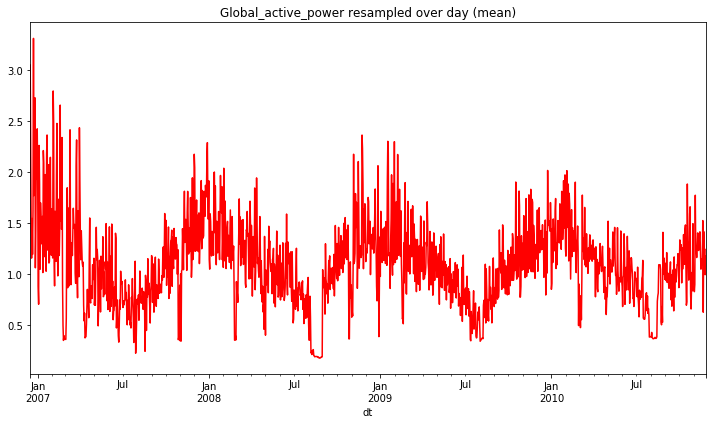

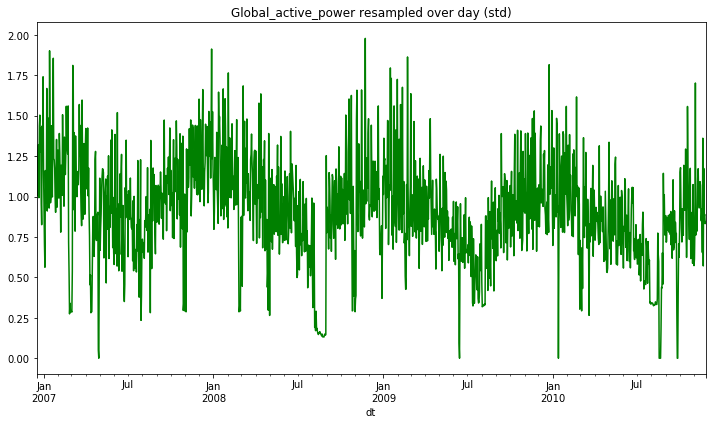

In [10]:
df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day (mean)', color='red',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Global_active_power.resample('D').std().plot(title='Global_active_power resampled over day (std)', color='green',figsize=(10,6)) 
plt.tight_layout()
plt.show()

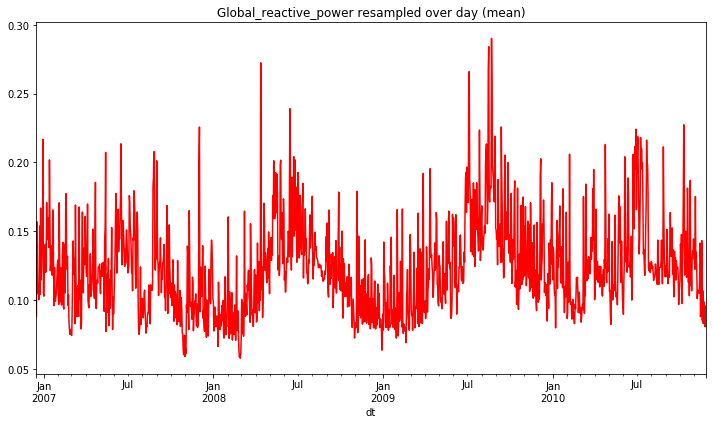

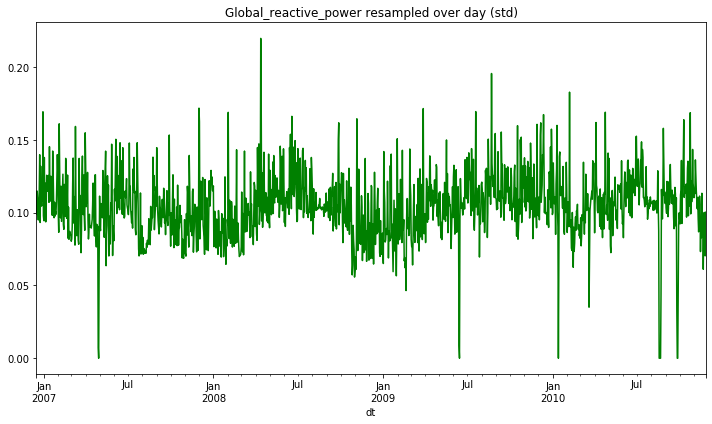

In [11]:
df.Global_reactive_power.resample('D').mean().plot(title='Global_reactive_power resampled over day (mean)', color='red',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Global_reactive_power.resample('D').std().plot(title='Global_reactive_power resampled over day (std)', color='green',figsize=(10,6)) 
plt.tight_layout()
plt.show()

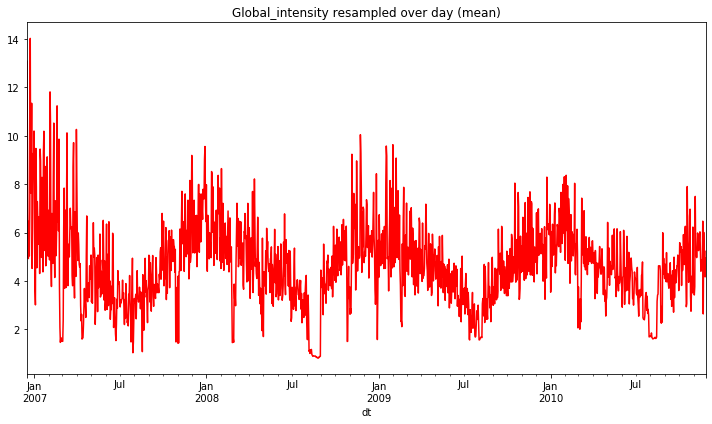

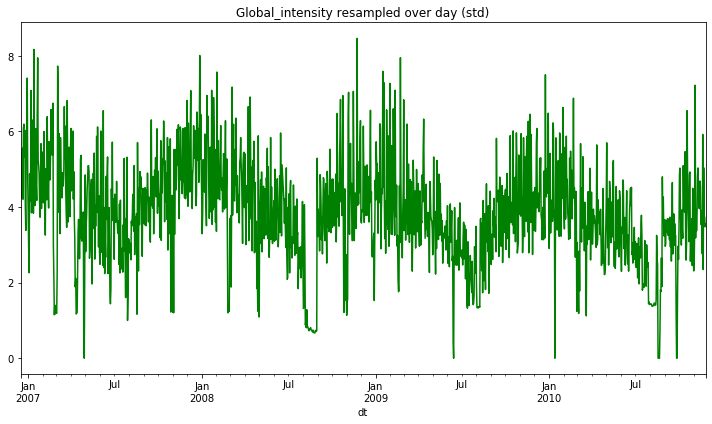

In [12]:
df.Global_intensity.resample('D').mean().plot(title='Global_intensity resampled over day (mean)', color='red',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Global_intensity.resample('D').std().plot(title='Global_intensity resampled over day (std)', color='green',figsize=(10,6)) 
plt.tight_layout()
plt.show()

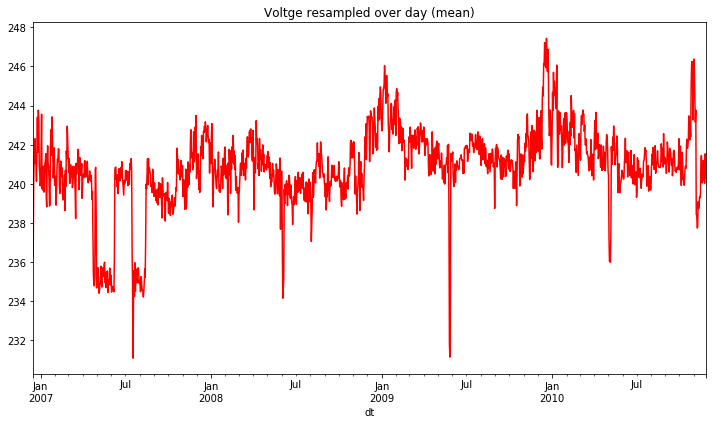

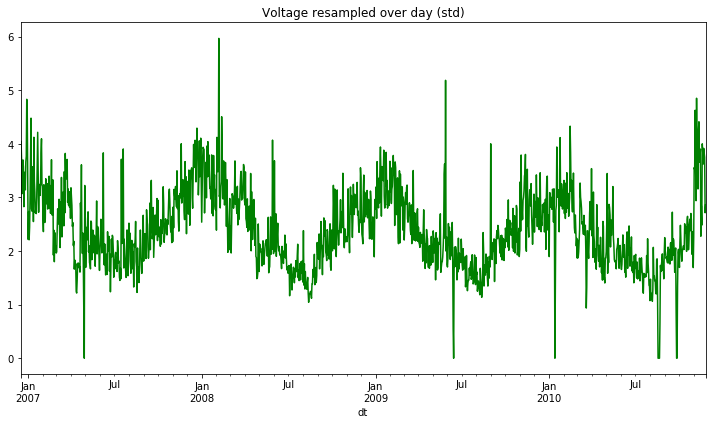

In [13]:
df.Voltage.resample('D').mean().plot(title='Voltge resampled over day (mean)', color='red',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Voltage.resample('D').std().plot(title='Voltage resampled over day (std)', color='green',figsize=(10,6)) 
plt.tight_layout()
plt.show()

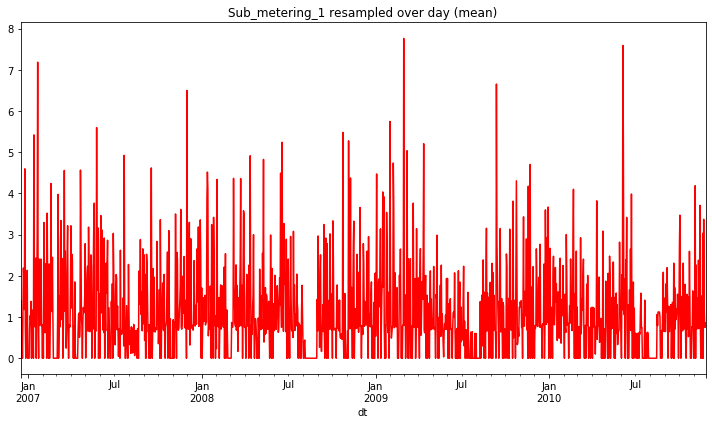

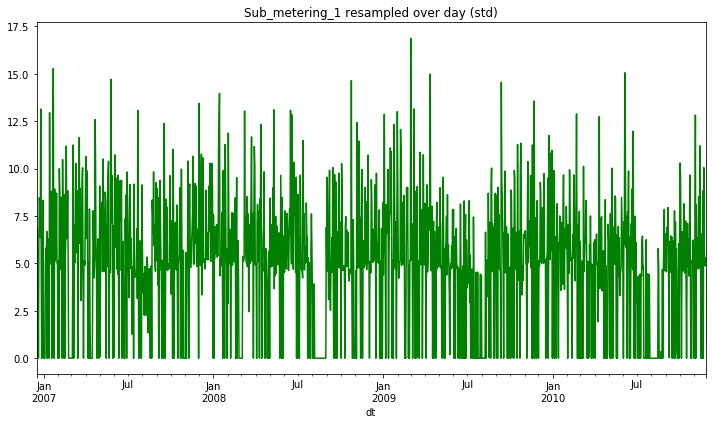

In [14]:
df.Sub_metering_1.resample('D').mean().plot(title='Sub_metering_1 resampled over day (mean)', color='red',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Sub_metering_1.resample('D').std().plot(title='Sub_metering_1 resampled over day (std)', color='green',figsize=(10,6)) 
plt.tight_layout()
plt.show()

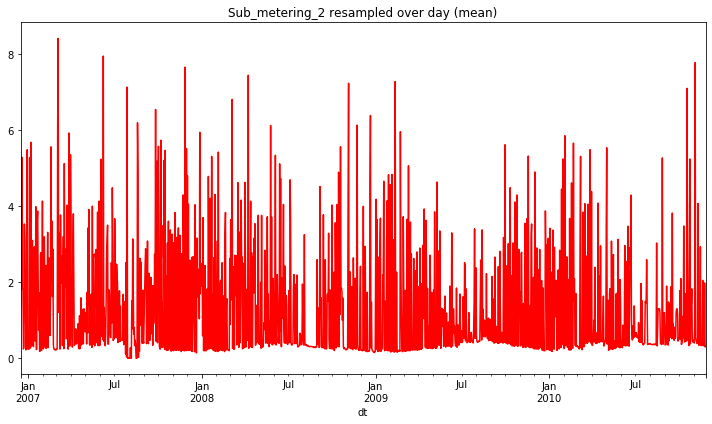

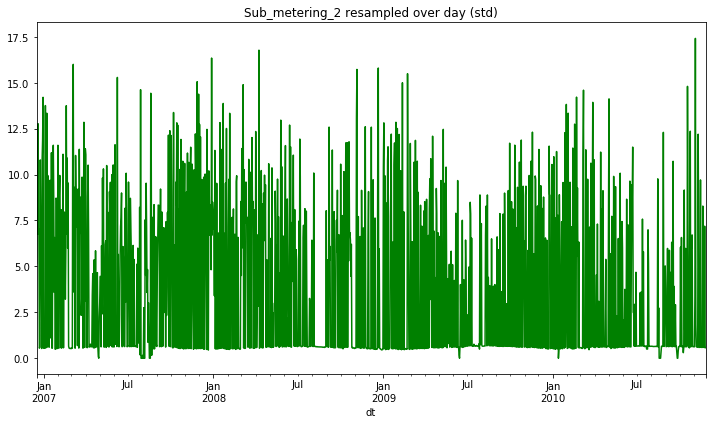

In [15]:
df.Sub_metering_2.resample('D').mean().plot(title='Sub_metering_2 resampled over day (mean)', color='red',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Sub_metering_2.resample('D').std().plot(title='Sub_metering_2 resampled over day (std)', color='green',figsize=(10,6)) 
plt.tight_layout()
plt.show()

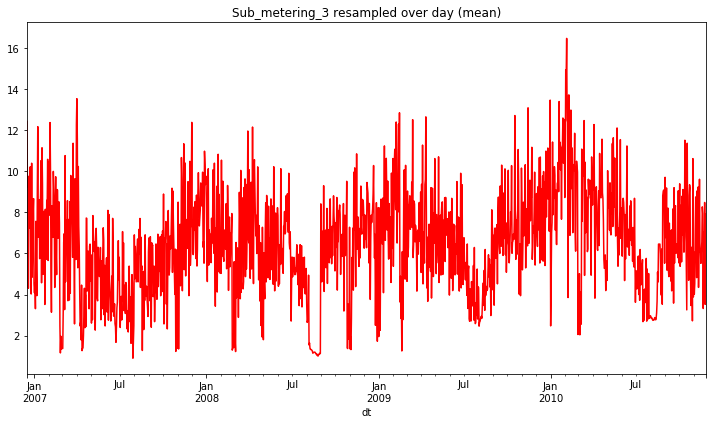

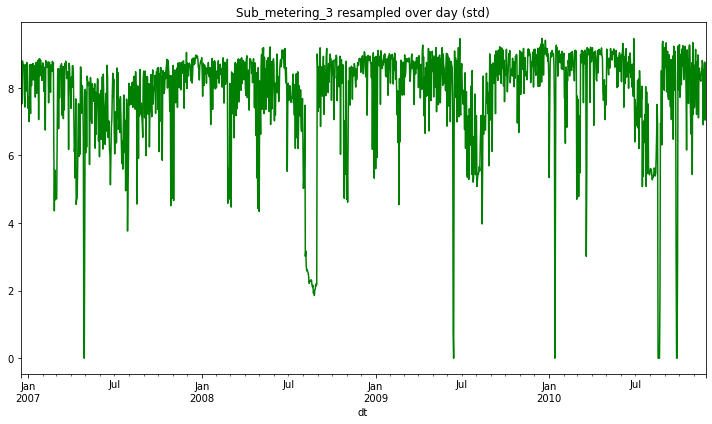

In [16]:
df.Sub_metering_3.resample('D').mean().plot(title='Sub_metering_3 resampled over day (mean)', color='red',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Sub_metering_3.resample('D').std().plot(title='Sub_metering_3 resampled over day (std)', color='green',figsize=(10,6)) 
plt.tight_layout()
plt.show()

### b) Resampling data over month

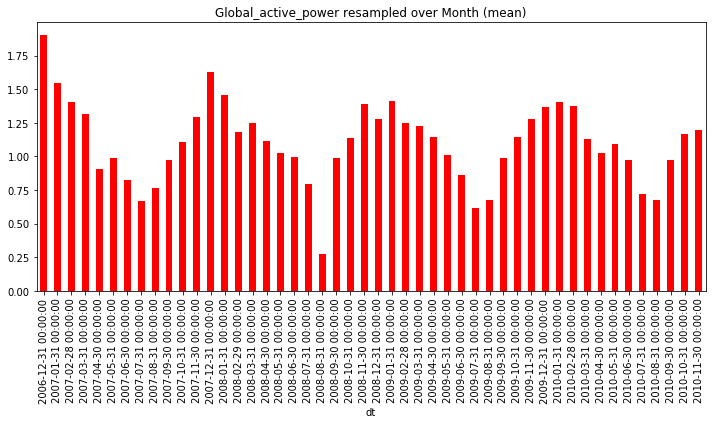

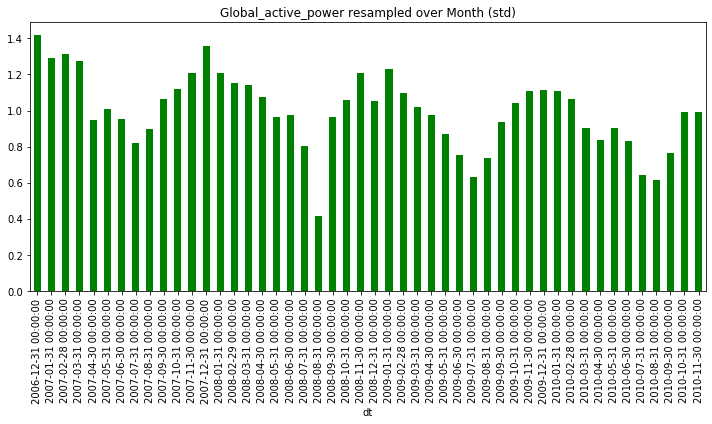

In [17]:
df.Global_active_power.resample('M').mean().plot(title='Global_active_power resampled over Month (mean)',kind ='bar', color='red',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Global_active_power.resample('M').std().plot(title='Global_active_power resampled over Month (std)',kind ='bar', color='green',figsize=(10,6)) 
plt.tight_layout()
plt.show()

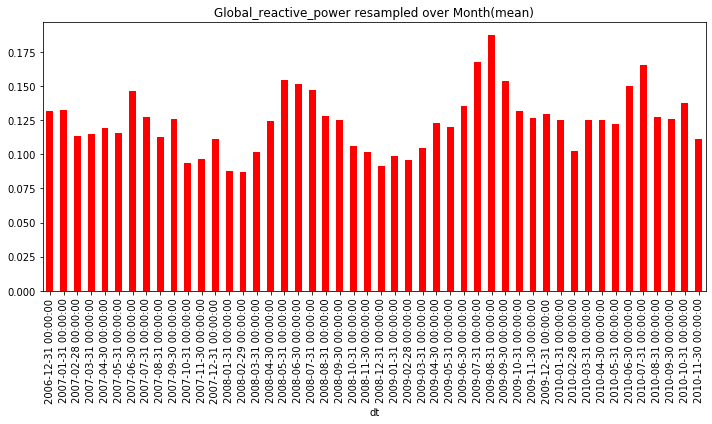

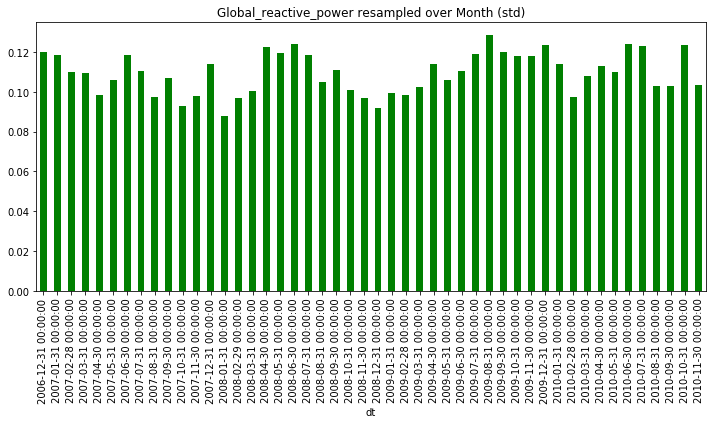

In [18]:
df.Global_reactive_power.resample('M').mean().plot(title='Global_reactive_power resampled over Month(mean)',kind = 'bar',color='red',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Global_reactive_power.resample('M').std().plot(title='Global_reactive_power resampled over Month (std)',kind = 'bar', color='green',figsize=(10,6)) 
plt.tight_layout()
plt.show()

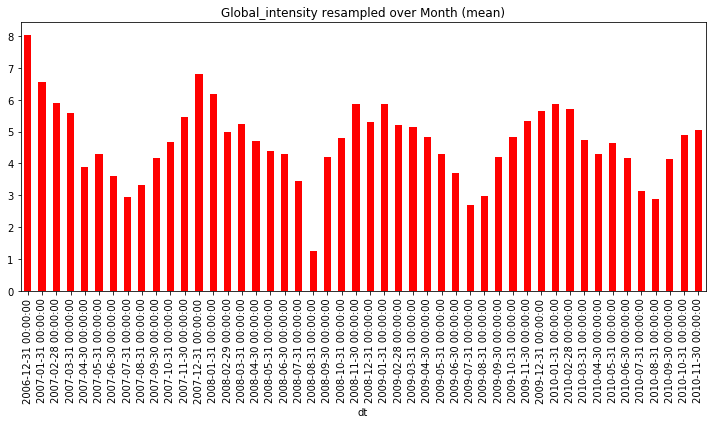

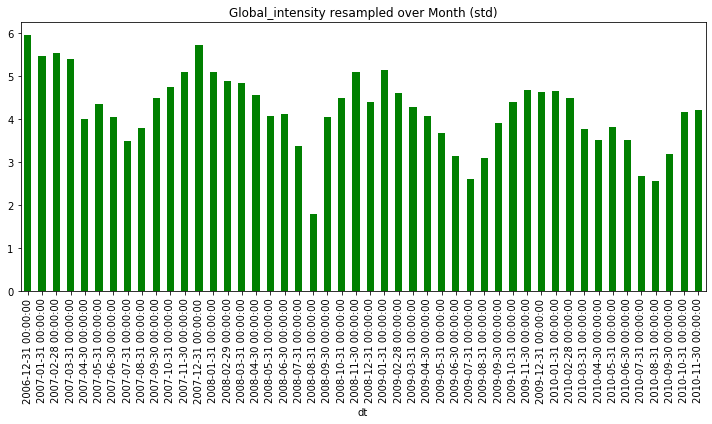

In [19]:
df.Global_intensity.resample('M').mean().plot(title='Global_intensity resampled over Month (mean)',kind = 'bar', color='red',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Global_intensity.resample('m').std().plot(title='Global_intensity resampled over Month (std)',kind='bar', color='green',figsize=(10,6)) 
plt.tight_layout()
plt.show()

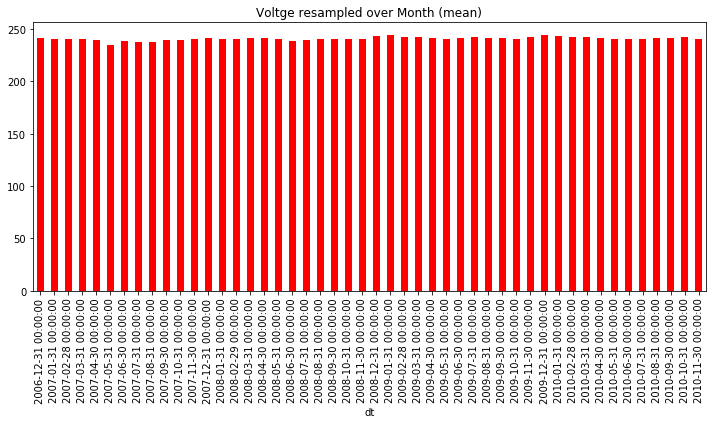

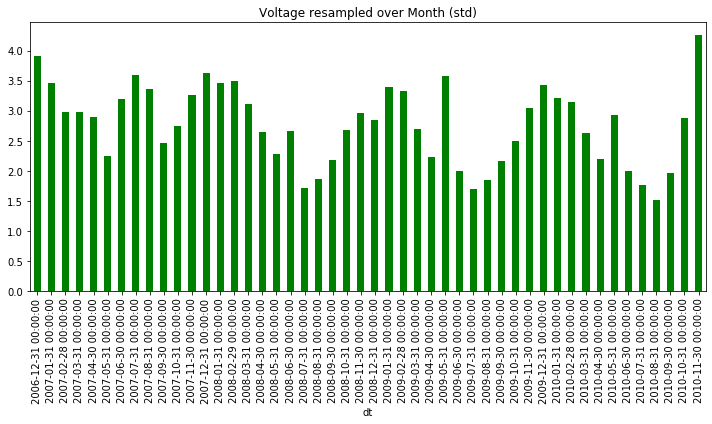

In [20]:
df.Voltage.resample('M').mean().plot(title='Voltge resampled over Month (mean)', color='red',kind = 'bar',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Voltage.resample('M').std().plot(title='Voltage resampled over Month (std)', color='green',kind='bar',figsize=(10,6)) 
plt.tight_layout()
plt.show()

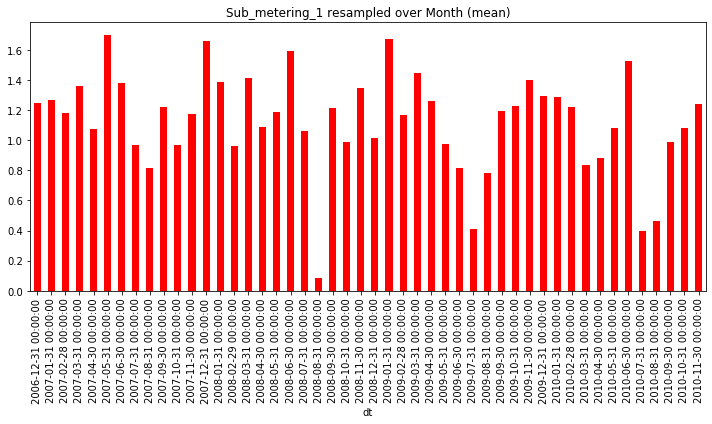

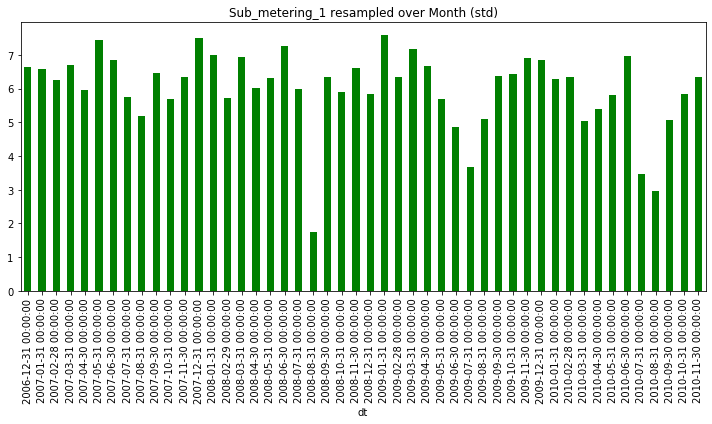

In [21]:
df.Sub_metering_1.resample('M').mean().plot(title='Sub_metering_1 resampled over Month (mean)',kind = 'bar', color='red',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Sub_metering_1.resample('M').std().plot(title='Sub_metering_1 resampled over Month (std)',kind = 'bar',color='green',figsize=(10,6)) 
plt.tight_layout()
plt.show()

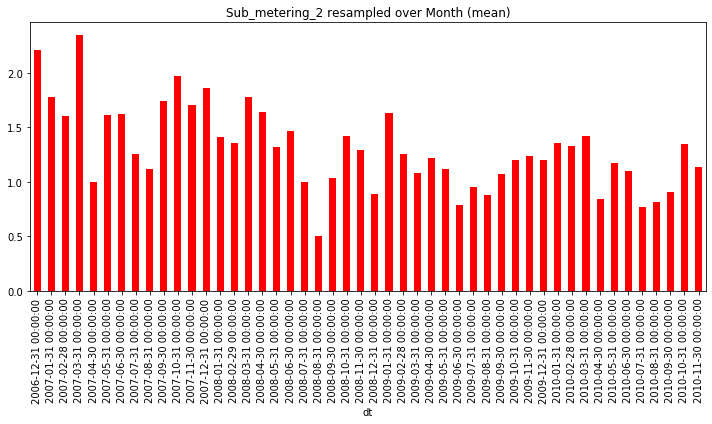

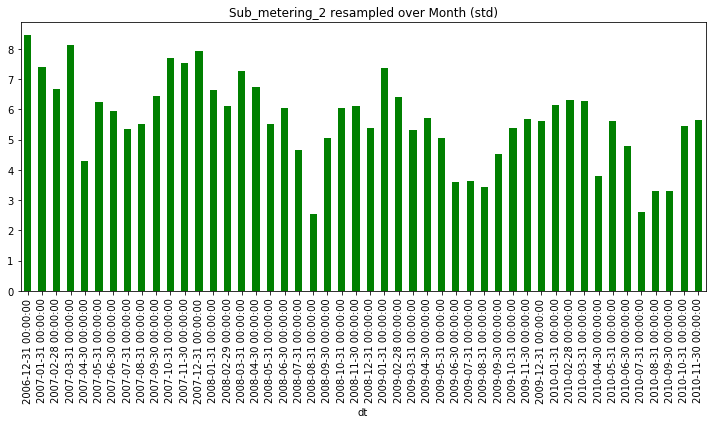

In [22]:
df.Sub_metering_2.resample('M').mean().plot(title='Sub_metering_2 resampled over Month (mean)',kind = 'bar', color='red',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Sub_metering_2.resample('M').std().plot(title='Sub_metering_2 resampled over Month (std)',kind = 'bar',color='green',figsize=(10,6)) 
plt.tight_layout()
plt.show()

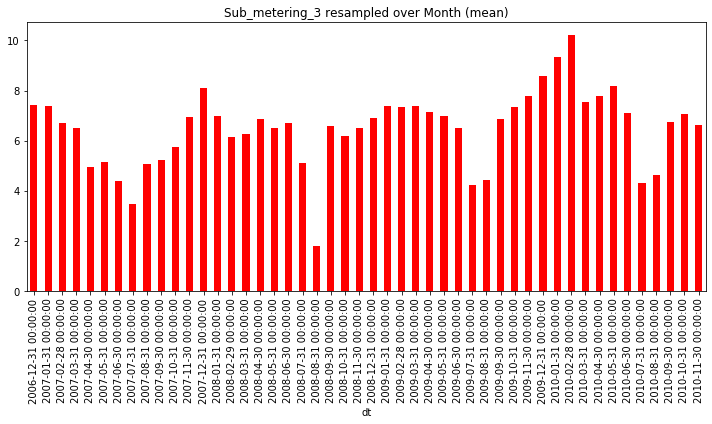

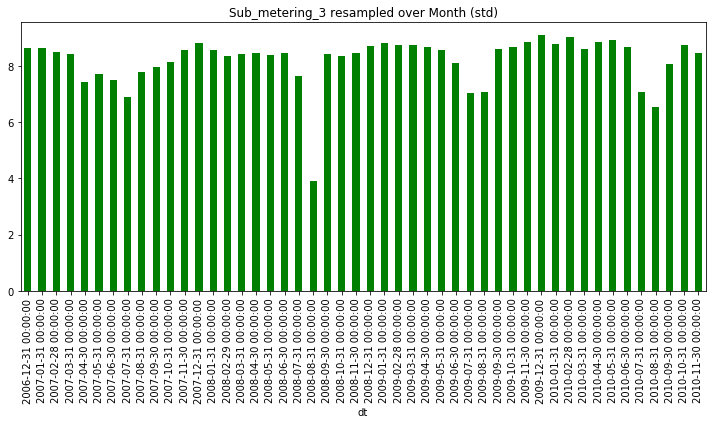

In [23]:
df.Sub_metering_3.resample('M').mean().plot(title='Sub_metering_3 resampled over Month (mean)',kind = 'bar', color='red',figsize=(10,6)) 
plt.tight_layout()
plt.show()

df.Sub_metering_3.resample('M').std().plot(title='Sub_metering_3 resampled over Month (std)',kind = 'bar',color='green',figsize=(10,6)) 
plt.tight_layout()
plt.show()

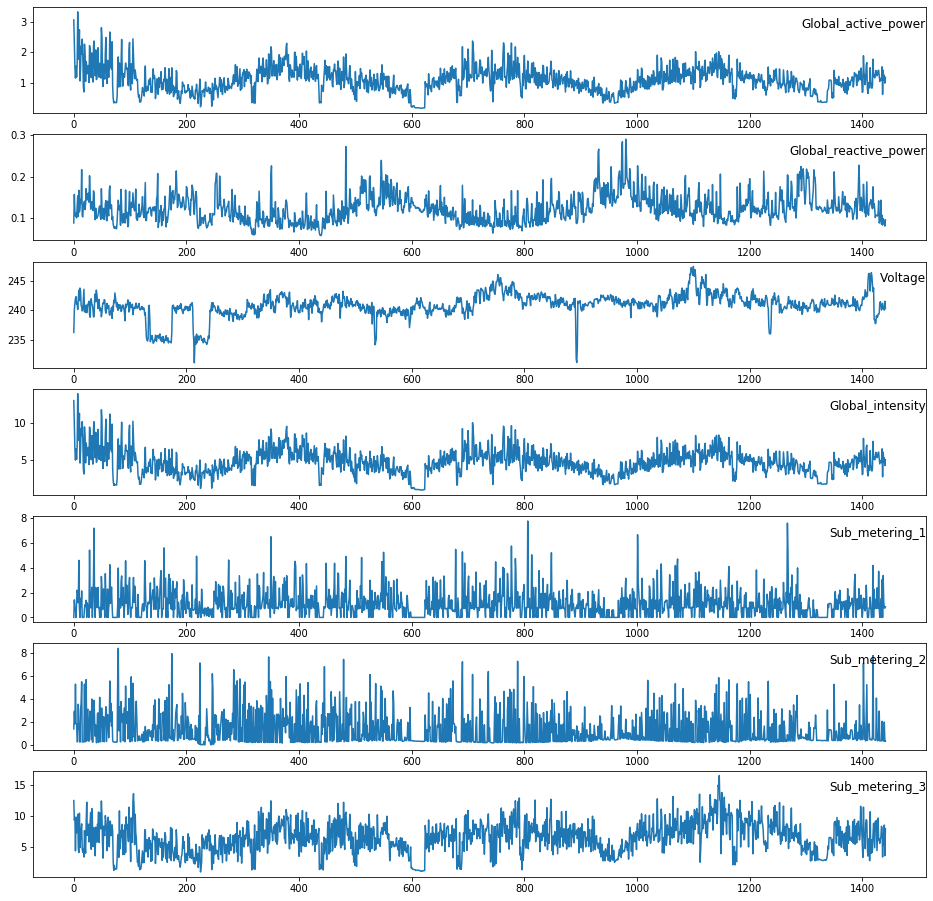

In [24]:
cols = [0,1,2,3,4,5,6]
i=1
values = df.resample('D').mean().values
plt.figure(figsize=(16,16))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(values[:, col])
    plt.title(df.columns[col], y=0.75, loc='right')
    i += 1
plt.show()

### c) relation between attributes

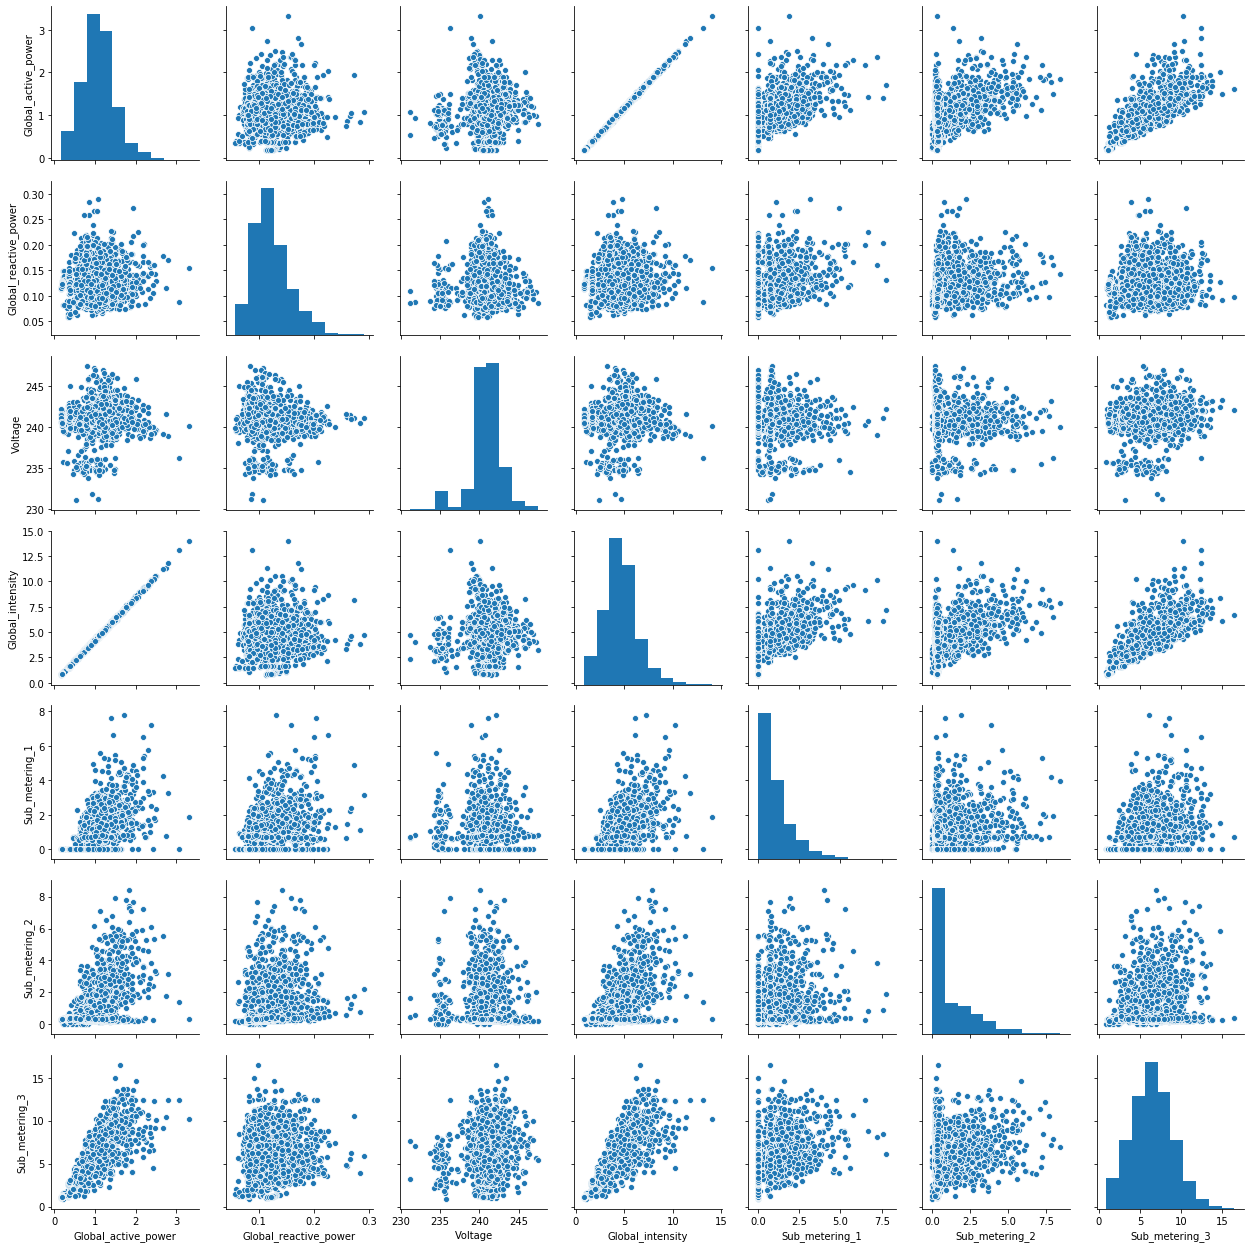

In [25]:
sns.pairplot(df.resample('D').mean())

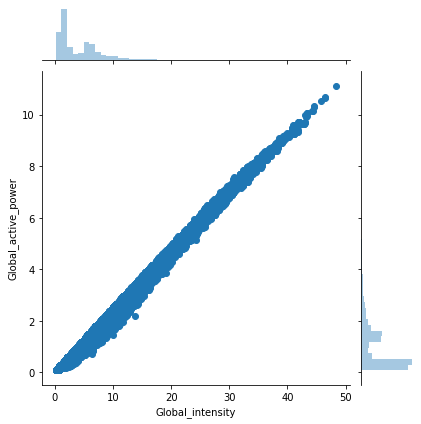

In [26]:
# Global active power vs Global Intensity

sns.jointplot(x='Global_intensity',y='Global_active_power',data=df)

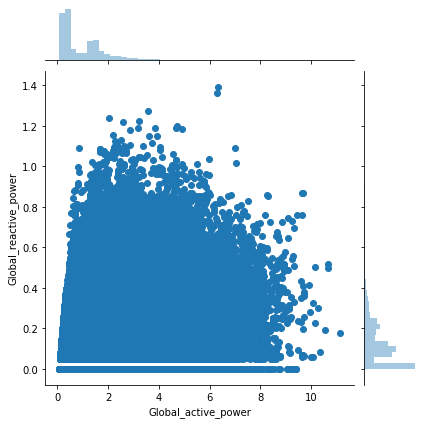

In [27]:
#Global_active_power vs Global_active_power

sns.jointplot(x='Global_active_power', y='Global_reactive_power',data=df)

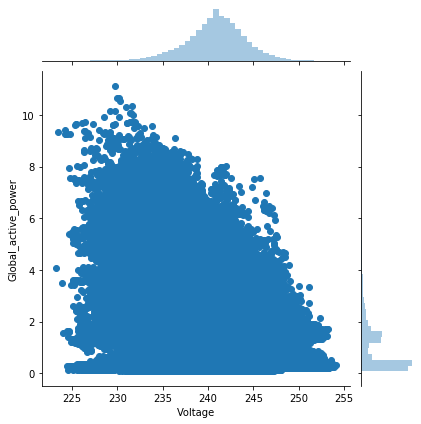

In [28]:
#Global active power vs voltage

sns.jointplot(x='Voltage', y='Global_active_power',data=df)

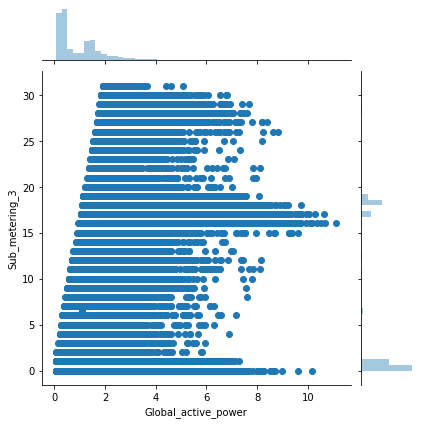

In [29]:
#Global_active_power vs sub_metering3

sns.jointplot(x='Global_active_power',y='Sub_metering_3',data=df)

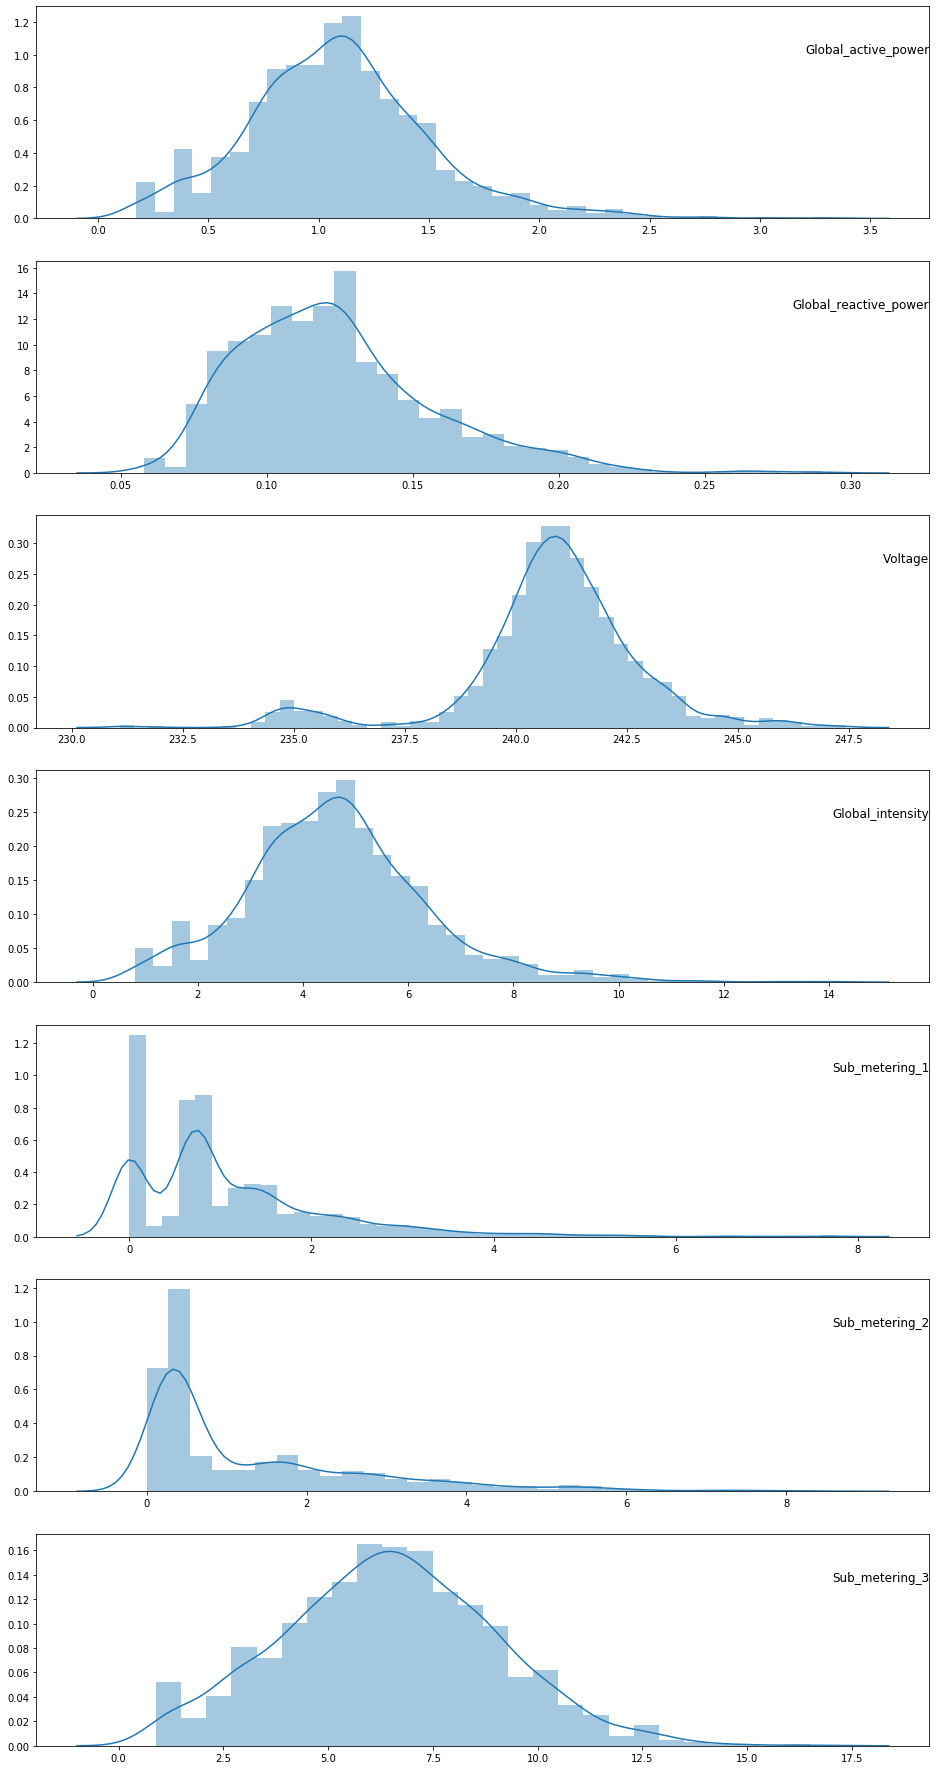

In [30]:
#Distribution Plots
cols = [0,1,2,3,4,5,6]
i=1
values = df.resample('D').mean().values
plt.figure(figsize=(16,32))
for col in cols:
    plt.subplot(len(cols), 1, i)
    sns.distplot(values[:, col])
    plt.title(df.columns[col], y=0.75, loc='right')
    i += 1
plt.show()

### Correlation Analysis

Text(0.5, 1, 'Without Sampling')

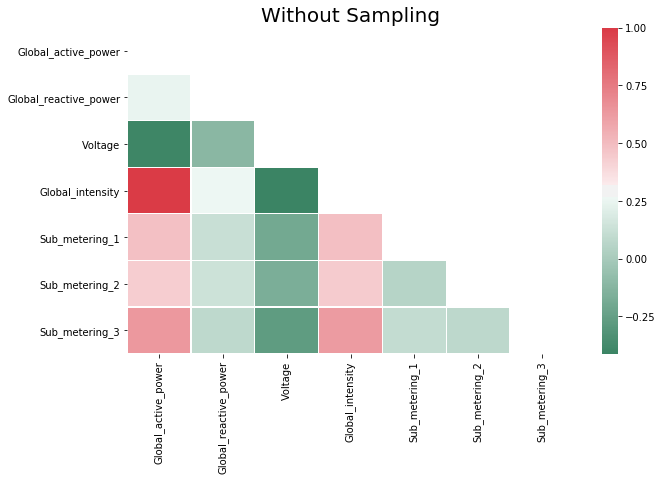

In [31]:
plt.figure(figsize=(10,6))

mask = np.zeros_like(df.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(150,10,as_cmap=True)
sns.heatmap(df.corr(),linecolor='w',linewidths=0.2,cmap=cmap,mask=mask)
plt.title('Without Sampling',size=20)

Text(0.5, 1, 'Sampled over month')

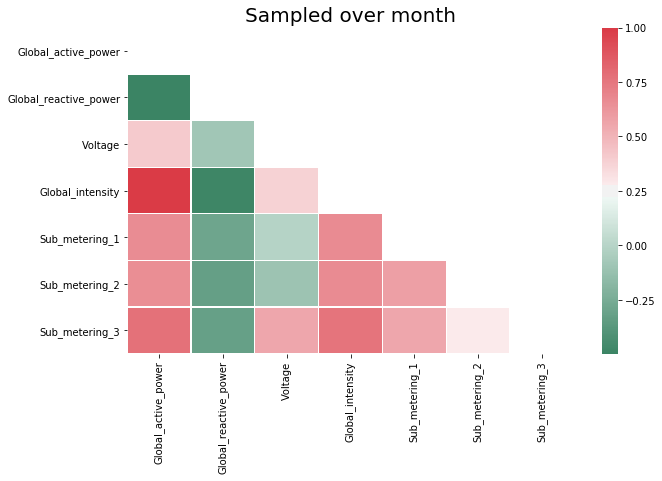

In [32]:
plt.figure(figsize=(10,6))

mask = np.zeros_like(df.resample('M').mean().corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(150,10,as_cmap=True)
sns.heatmap(df.resample('M').mean().corr(),linecolor='w',linewidths=0.2,cmap=cmap,mask=mask)
plt.title('Sampled over month',size=20)

Text(0.5, 1, 'Sampled over Year')

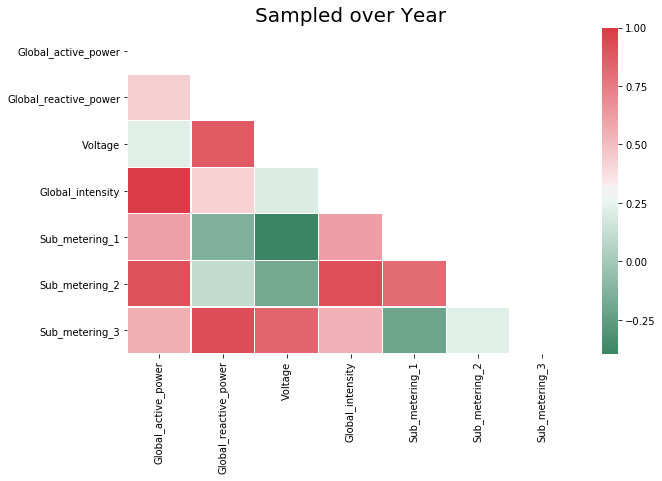

In [33]:
plt.figure(figsize=(10,6))

mask = np.zeros_like(df.resample('Y').mean().corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(150,10,as_cmap=True)
sns.heatmap(df.resample('y').mean().corr(),linecolor='w',linewidths=0.2,cmap=cmap,mask=mask)
plt.title('Sampled over Year',size=20)

## 2.Model Building

### 2.1 VAR(Vector AutoRegression Model)

In [44]:
# Checking Stationarity
from statsmodels.tsa .vector_ar.vecm import coint_johansen
coint_johansen(df,-1,1).eig

array([1.11661016e-01, 6.52021385e-02, 4.14477999e-02, 2.46315699e-02,
       1.71063323e-02, 9.29255365e-03, 1.13557492e-06])

The above result shows that the timeseries is stationarity.

In [36]:
#creating the train and validation set
train = df[:int(0.8*(len(df)))]
valid = df[int(0.8*(len(df))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


The predictions are in the form of an array, where each list represents the predictions of the row. We will transform this into a more presentable format.

In [39]:
import math

In [40]:
#converting predictions to dataframe
cols = df.columns
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for Global_active_power is :  0.8789074902862689
rmse value for Global_reactive_power is :  0.11312718474019288
rmse value for Voltage is :  2.7089060949363866
rmse value for Global_intensity is :  3.6936845531032922
rmse value for Sub_metering_1 is :  5.432849885675757
rmse value for Sub_metering_2 is :  4.819968436813302
rmse value for Sub_metering_3 is :  8.423174491945


After the testing on validation set, lets fit the model on the complete dataset

In [41]:
#make final predictions
model = VAR(endog=df)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


### 2.2 Deep Learning model using LSTM

In [112]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
        # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
        # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [113]:
# sampling data in terms of hours to reduce the size of the data
df = df.resample('h').mean()
#converting dataframe into numpy values
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283801   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315988   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.782418  0.545045  
2   0.782676  0.509006  
3   0.774169  0.488550  
4   0.778809  0.455597  
5   0.798917  0.322555  


In [78]:
reframed.shape

(34588, 8)

In [136]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 7) (26280,) (8308, 1, 7) (8308,)


Train on 26280 samples, validate on 8308 samples
Epoch 1/20
 - 3s - loss: 0.0149 - val_loss: 0.0083
Epoch 2/20
 - 2s - loss: 0.0100 - val_loss: 0.0079
Epoch 3/20
 - 2s - loss: 0.0096 - val_loss: 0.0081
Epoch 4/20
 - 2s - loss: 0.0097 - val_loss: 0.0079
Epoch 5/20
 - 2s - loss: 0.0096 - val_loss: 0.0078
Epoch 6/20
 - 2s - loss: 0.0096 - val_loss: 0.0077
Epoch 7/20
 - 2s - loss: 0.0096 - val_loss: 0.0077
Epoch 8/20
 - 2s - loss: 0.0096 - val_loss: 0.0078
Epoch 9/20
 - 3s - loss: 0.0096 - val_loss: 0.0077
Epoch 10/20
 - 2s - loss: 0.0095 - val_loss: 0.0077
Epoch 11/20
 - 2s - loss: 0.0095 - val_loss: 0.0077
Epoch 12/20
 - 3s - loss: 0.0095 - val_loss: 0.0076
Epoch 13/20
 - 3s - loss: 0.0095 - val_loss: 0.0077
Epoch 14/20
 - 3s - loss: 0.0094 - val_loss: 0.0077
Epoch 15/20
 - 2s - loss: 0.0095 - val_loss: 0.0077
Epoch 16/20
 - 2s - loss: 0.0094 - val_loss: 0.0077
Epoch 17/20
 - 2s - loss: 0.0094 - val_loss: 0.0077
Epoch 18/20
 - 2s - loss: 0.0094 - val_loss: 0.0076
Epoch 19/20
 - 2s - loss

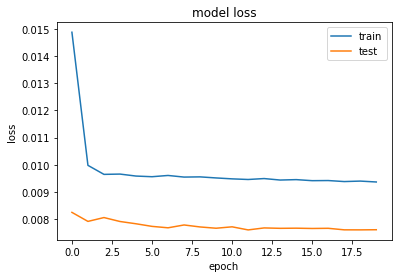

In [140]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(70,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(40))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [141]:
# make a forecast
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
yhat = yhat.reshape((yhat.shape[0], 1))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.562
